# Dataset Exploration

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import coint, adfuller
import statsmodels.api as sm
import numpy as np

In [2]:
# load data into dataframe
df = pd.read_csv("final_data_10s.csv")
initial_length = len(df)

# check for missing values
df.dropna(inplace=True)

# modify "Time" column to all be datetime, else becomes NaT to be dropped in the next line
df['Time'] = pd.to_datetime(df['Time'], errors='coerce')
# drop any rows with null values
df.dropna(inplace=True)

# check following columns for negative values
negative_check_columns = ['X_BID', 'X_BID_VOL', 'X_ASK', 'X_ASK_VOL', 'Y_BID', 'Y_BID_VOL', 'Y_ASK', 'Y_ASK_VOL']
negative_values_condition = (df[negative_check_columns] < 0).any(axis=1)
negative_rows = df[negative_values_condition]
df = df[~negative_values_condition]

# check that ask > bid for X and Y and remove them
ask_bid_violation_condition = (df['X_ASK'] <= df['X_BID']) | (df['Y_ASK'] <= df['Y_BID'])
violation_rows = df[ask_bid_violation_condition]
df = df[~ask_bid_violation_condition]

# check for non-integer volumes and 0 volumes
volume_columns = ['X_BID_VOL', 'X_ASK_VOL', 'Y_BID_VOL', 'Y_ASK_VOL']
non_integer_volumes_condition = df[volume_columns].apply(lambda x: x % 1 != 0 | (x == 0)).any(axis=1)
non_integer_volume_rows = df[non_integer_volumes_condition]
df = df[~non_integer_volumes_condition]

final_length = len(df)
print("Rows removed: ", initial_length - final_length)

Rows removed:  174


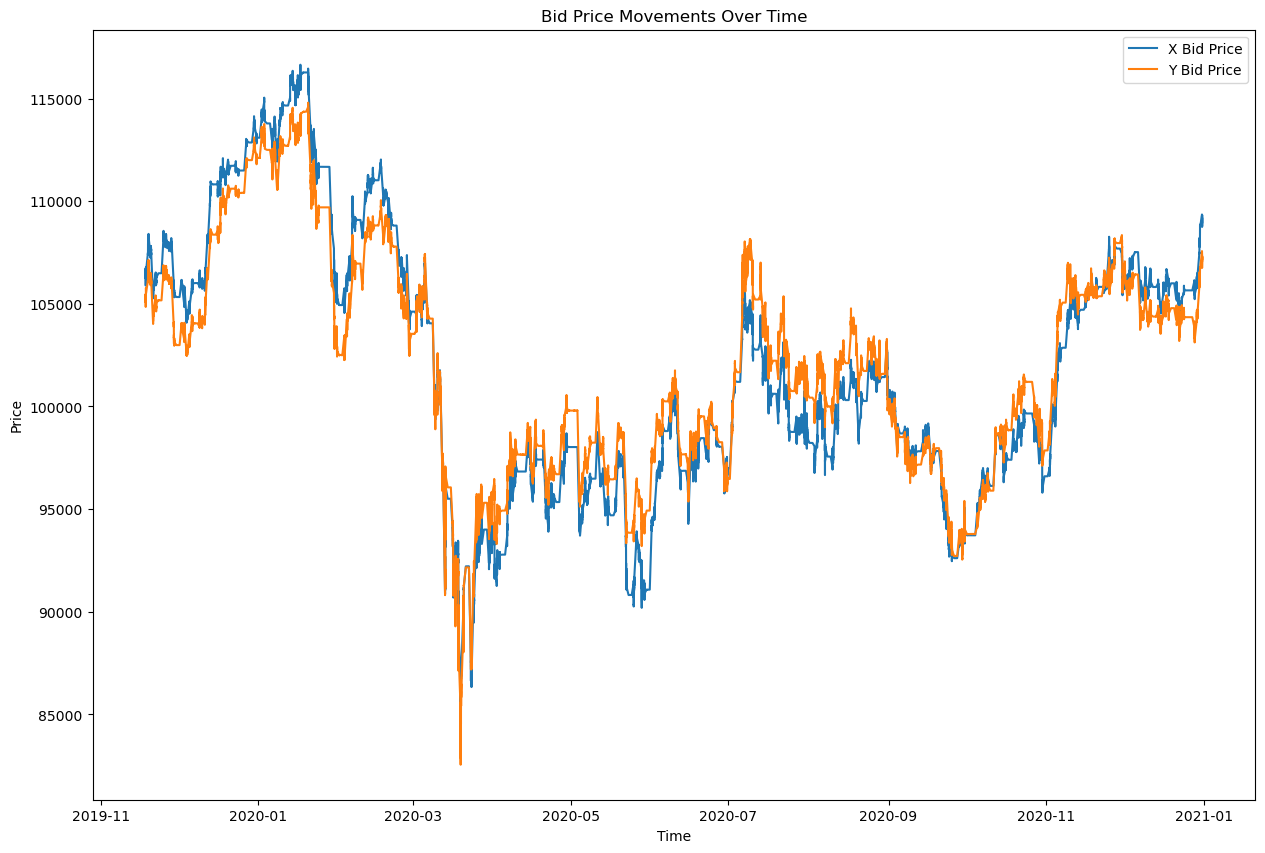

In [3]:
plt.figure(figsize=(15, 10))
plt.plot(df['Time'], df['X_BID'], label='X Bid Price')
plt.plot(df['Time'], df['Y_BID'], label='Y Bid Price')
plt.title('Bid Price Movements Over Time')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

With a broad view, it looks like there is high correlation between both instrument X and Y. To analyse further, I will start with their statistics to gauge the general idea of the instruments

In [4]:
summary_stats = df.describe()
summary_stats_all = df.describe(include='all', datetime_is_numeric=True)
print(summary_stats)

               X_BID      X_BID_VOL          X_ASK      X_ASK_VOL  \
count  737565.000000  737565.000000  737565.000000  737565.000000   
mean   101809.285636       4.955490  101823.617612       3.571125   
std      6327.424018      16.523856    6326.913997       3.635911   
min     83896.000000       1.000000   83916.000000       1.000000   
25%     97148.000000       1.000000   97152.000000       2.000000   
50%    100440.000000       3.000000  100448.000000       3.000000   
75%    106040.000000       5.000000  106048.000000       5.000000   
max    116648.000000     586.000000  116652.000000     410.000000   

               Y_BID      Y_BID_VOL          Y_ASK      Y_ASK_VOL  
count  737565.000000  737565.000000  737565.000000  737565.000000  
mean   102009.287087      10.783089  102029.571631      10.071625  
std      5387.228495      15.822869    5386.059909       9.681551  
min     82550.000000       1.000000   82570.000000       1.000000  
25%     97960.000000       4.000000   

1. From the summary statistics, we have a consistent 737565 rows of data after cleaning
2. The mean and median are relatively close to bid and ask prices, hinting at a symmetric distribution
3. Instrument Y trades at a slightly higher price level than X on average
4. Y's standard deviation is lower than X, showing Y has lower variability / less volatile
5. Average X bid volume (4.955) and ask volume (3.57) is lower than average Y bid volume (10.78) and ask volume (10.07), indicating Y has higher trading activity and possibly more liquidity than X
6. Standard deviation for both instruments in bid and ask volumes is significantly higher than the mean, indicating patterns of high trading activity interspersed with lower trading activity
7. X has a greater max bid volume and ask volume than Y, indicating that while Y has a more consistent trading activity, X is more volatile and sees higher peaks - aggreeing with point 4

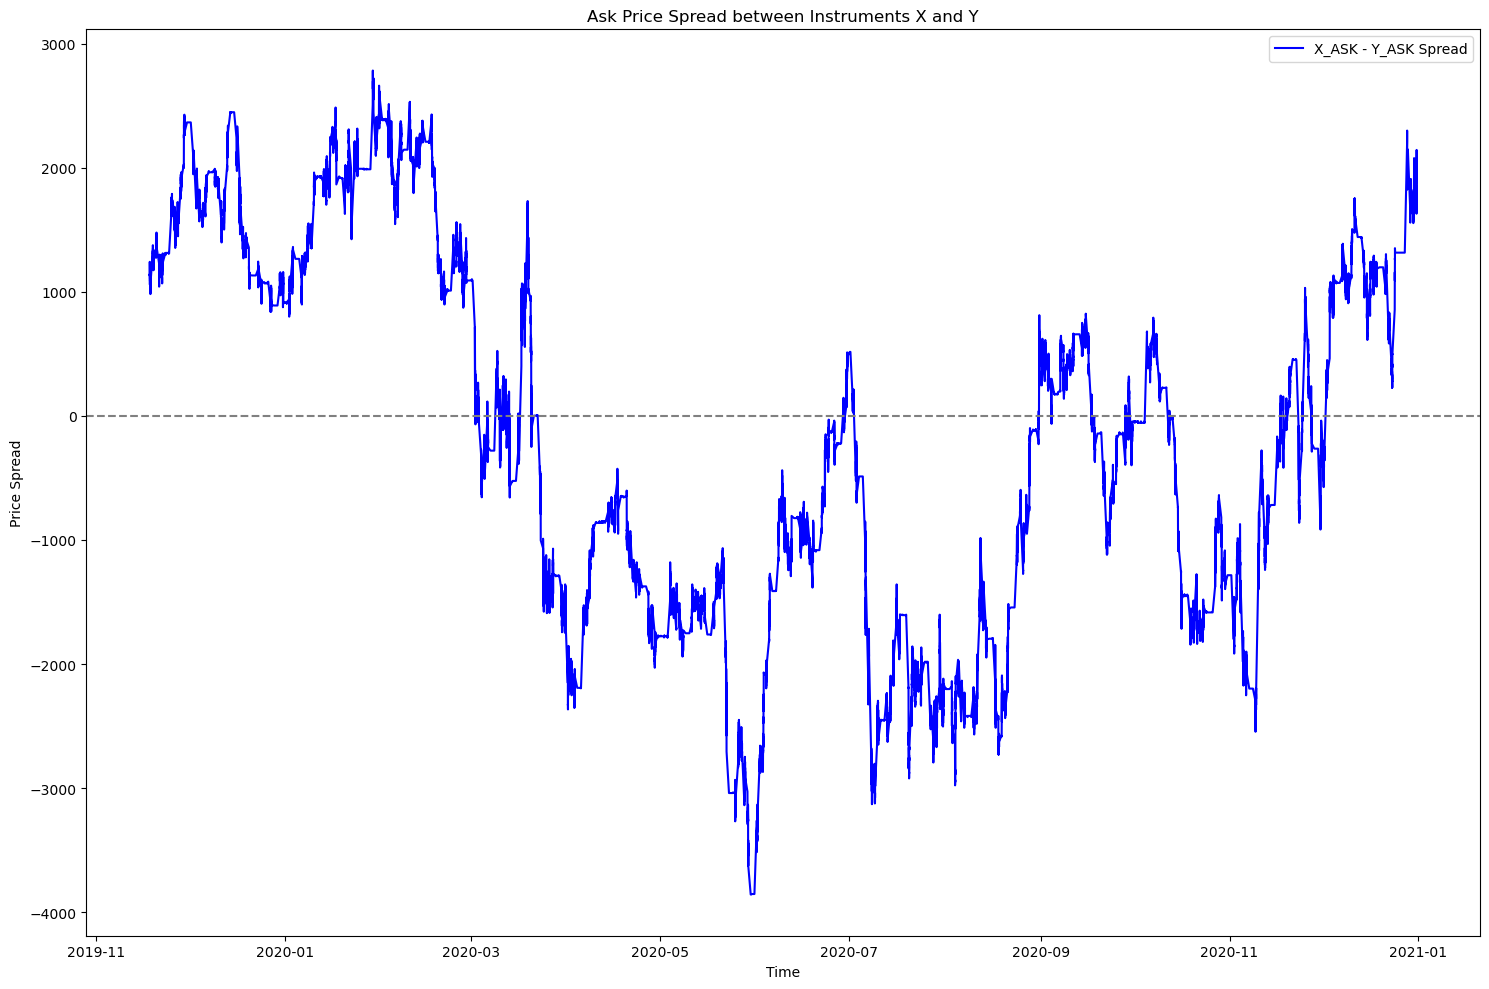

In [5]:
fig, ax = plt.subplots(figsize=(15, 10))

# Plotting the difference between X_ASK and Y_ASK
ax.plot(df['Time'], df['X_ASK'] - df['Y_ASK'], label='X_ASK - Y_ASK Spread', color='blue', linestyle='-')

# Adding a horizontal line at zero for reference
ax.axhline(0, color='gray', linestyle='--')

ax.set_title('Ask Price Spread between Instruments X and Y')
ax.set_xlabel('Time')
ax.set_ylabel('Price Spread')
ax.legend()
plt.tight_layout()
plt.show()

This graph shows the difference in asking prices for X and Y. If the price spread $\ge0$ then it means that X has a higher price than Y. This graph is very volatile and can be broken down into the following sections:

## START to 2020-02
At this range, X is consistently higher priced than Y, indicating its true value without environmental factors

## 2020-02 to 2020-03
This is the start of the COVID pandemic. During this time, businesses shutdown and consumers were locked inside, causing a sharp decline in economic activity. The fear of the virus significantly reduced consumer spending and as a result, the price of X and Y dropped. However according to the graph, it is clear that the price of X dropped significantly faster than Y, causing them to be equalised (same price) at the end of the month.

## 2020-03 to 2020-03 (mid)
Towards the mid of March, the government responded with fiscal and monetary stimulus measures to support economics, businesses and people who lost their jobs. This positive response caused X to skyrocket in price, returning to roughly the same as before the pandemic started. This shows that X responds positively to government interventions and has a higher sensitivity to economic recovery efforts than Y. The rapid increase in X's price during this period suggests that investors may view X as more resilient or better positioned to benefit from economic stimulus measures. This could be due to the nature of the business / sector X represents.

## 2020-03 (mid) to 2020-06
In this period, the price of Y fell significantly slower than X, starting with X being greater than Y by about 1500 to X being lower than Y about 3800. 
This could be possibly due to 
1. The overly optimistic surge in X's price to the support; investors became too optimistic about the future of X leading to a market correction
2. Rising concerns and potential second wave of COVID infections

So far, X has been seen as much more volatile compared Y. Because of this, X can be seen as residing in the technology sector/energy sector whereas Y resides in the health/essential services

## 2020-06 to END
At this range, the price spread between X and Y generally increases, with X's price rising faster than Y's. This trend suggests a recovery phase where investor confidence in X rebounds more robustly compared to Y because of factors such as:
1. Continued government support
2. Consumers and business adapting to the changes caused by COVID

# Measuring Correlation

In [6]:
# Pearson
pearson_corr = df[['X_BID', 'X_BID_VOL', 'X_ASK', 'X_ASK_VOL', 'Y_BID', 'Y_BID_VOL', 'Y_ASK', 'Y_ASK_VOL']].corr(method='pearson')
print("Pearson Correlation:\n", pearson_corr)

# Spearman
spearman_corr = df[['X_BID', 'X_BID_VOL', 'X_ASK', 'X_ASK_VOL', 'Y_BID', 'Y_BID_VOL', 'Y_ASK', 'Y_ASK_VOL']].corr(method='spearman')
print("\nSpearman Correlation:\n", spearman_corr)

Pearson Correlation:
               X_BID  X_BID_VOL     X_ASK  X_ASK_VOL     Y_BID  Y_BID_VOL  \
X_BID      1.000000  -0.100161  0.999997   0.085095  0.978963   0.062409   
X_BID_VOL -0.100161   1.000000 -0.100270   0.015151 -0.087692   0.010172   
X_ASK      0.999997  -0.100270  1.000000   0.084857  0.978922   0.062149   
X_ASK_VOL  0.085095   0.015151  0.084857   1.000000  0.080126   0.042591   
Y_BID      0.978963  -0.087692  0.978922   0.080126  1.000000   0.055868   
Y_BID_VOL  0.062409   0.010172  0.062149   0.042591  0.055868   1.000000   
Y_ASK      0.978974  -0.087795  0.978936   0.079726  0.999996   0.055984   
Y_ASK_VOL  0.048258  -0.028292  0.047955   0.059946  0.055780   0.098652   

              Y_ASK  Y_ASK_VOL  
X_BID      0.978974   0.048258  
X_BID_VOL -0.087795  -0.028292  
X_ASK      0.978936   0.047955  
X_ASK_VOL  0.079726   0.059946  
Y_BID      0.999996   0.055780  
Y_BID_VOL  0.055984   0.098652  
Y_ASK      1.000000   0.055707  
Y_ASK_VOL  0.055707   1.00000

Pearson
1. Almost perfect correlation (0.999997) between X_BID and X_ASK, and Y_BID and Y_ASK
2. Very high correlation between X_BID and Y_BID (0.978963)
3. Low correlation of (X_BID, X_ASK, Y_BID, Y_ASK) to volumes (X_BID_VOL, X_ASK_VOL, Y_BID_VOL, Y_ASK_VOL)
4. Point of interest: correlation between X_ASK_VOL and X_BID/X_ASK (0.085) is slightly elevated compared to average of others ~0.06

Spearman
1. Near perfect monotonic relationship between bid and ask prices
2. Strong monotonic relationship between X_BID and Y_BID (0.976682)
3. Slightly higher relationship between prices and volumes compared to Pearson, indicating monotonic but not linear relationship
4. Point of interest: much higher correlation (0.236037) than Pearson, further investigation is required

# Testing Stationarity

In [7]:
# commented because takes long time (1min)
def adf_test(series, name=''):
    print(f'ADF Test on "{name}"')
    result = adfuller(series.dropna(), autolag='AIC')
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    print('\n')

# take sample otherwise takes too long
sampled_df = df.sample(frac=0.2, random_state=42)

# skip time column
for column in df.columns[1:]:
    adf_test(sampled_df[column], name=column)

ADF Test on "X_BID"
ADF Statistic: -383.34846197857297
p-value: 0.0


ADF Test on "X_BID_VOL"
ADF Statistic: -269.6237117953573
p-value: 0.0


ADF Test on "X_ASK"
ADF Statistic: -383.34721399316396
p-value: 0.0


ADF Test on "X_ASK_VOL"
ADF Statistic: -135.29250008974145
p-value: 0.0


ADF Test on "Y_BID"
ADF Statistic: -384.02884504020926
p-value: 0.0


ADF Test on "Y_BID_VOL"
ADF Statistic: -384.7623326198537
p-value: 0.0


ADF Test on "Y_ASK"
ADF Statistic: -384.029710137053
p-value: 0.0


ADF Test on "Y_ASK_VOL"
ADF Statistic: -383.5820389145505
p-value: 0.0




After running the Augmented Dickey Fuller test, the p-value is approximately 0. This is below the common alpha level of 0.05 and hence we have very strong evidence to reject the null hypothesis. This suggests that the time series for each column does not have a unit root and is stationary. 

Therefore statistics such as mean, variance are constant and means that we can continue our statistical analysis without fear of non-stationarity series distorting the results found.

However a weakness is that only 20% of the dataset was used to test as it would take quite a lot of computational power. Whilist unlikely, it may have chosen the 'best' 20% of the dataset to get the lowest p-value.

# Testing Cointegration

In [8]:
_, pvalue, _ = coint(sampled_df['X_BID'],sampled_df['Y_BID']) # very similar to X_ASK and Y_ASK
print('Cointegration test p-value: ', pvalue)

_, pvalue, _ = coint(sampled_df['X_BID_VOL'],sampled_df['Y_BID_VOL'])
print('Cointegration test p-value: ', pvalue)

_, pvalue, _ = coint(sampled_df['X_ASK_VOL'],sampled_df['Y_ASK_VOL'])
print('Cointegration test p-value: ', pvalue)

Cointegration test p-value:  0.0
Cointegration test p-value:  0.0
Cointegration test p-value:  0.0


After conducting the Engle-Granger test on the same sampled 20% of the dataset, the p-value for these 3 pairs of interest are approximately 0. This indicates very strong evidence against the null hypothesis that there is no cointegration. 

This indicates that the prices and volumes of the instruments move together over the long term, even if they diverge in the short term.

# Linear Regression Spread

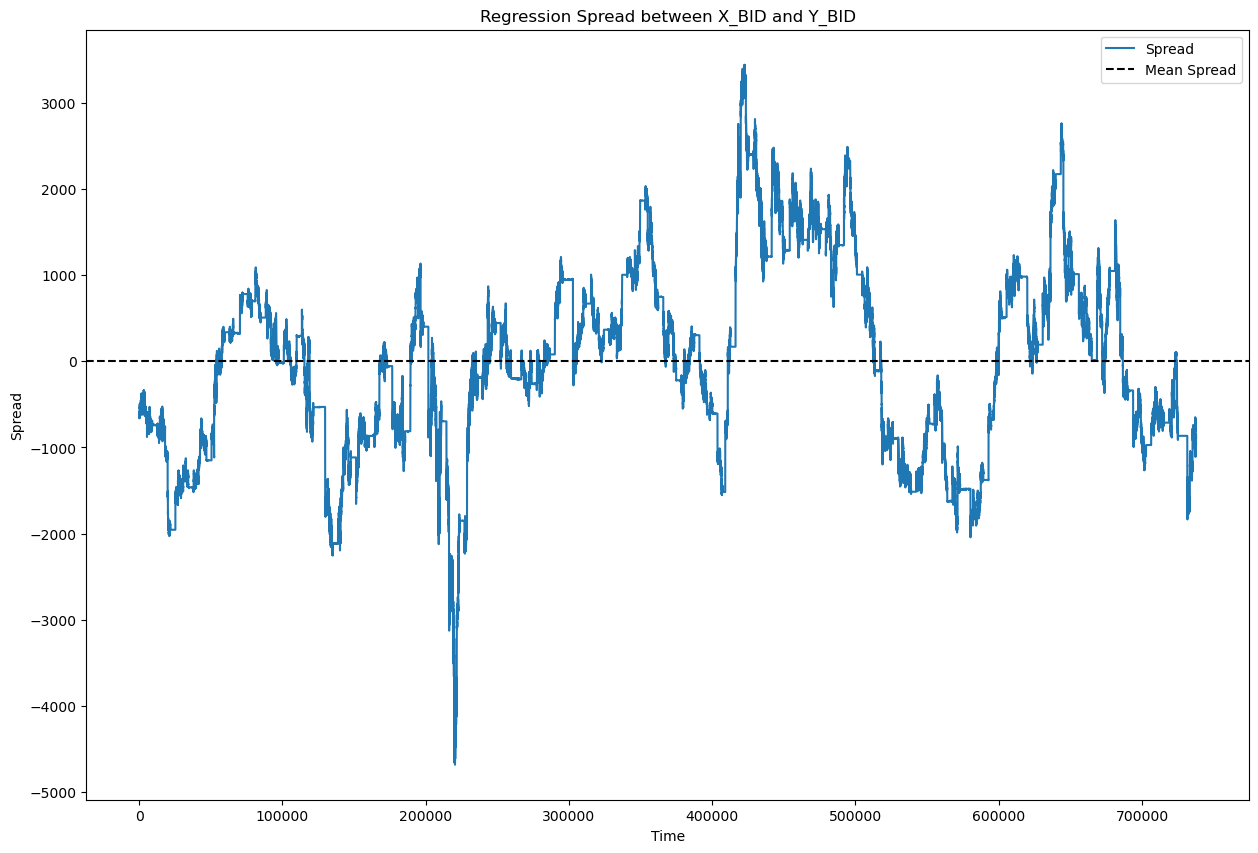

In [9]:
X = sm.add_constant(df['X_BID'])
Y = df['Y_BID']
model = sm.OLS(Y, X).fit()
df['Y_BID_pred'] = model.predict(X)
df['Spread'] = df['Y_BID'] - df['Y_BID_pred']

plt.figure(figsize=(15, 10))
df['Spread'].plot(title='Regression Spread between X_BID and Y_BID')
plt.axhline(df['Spread'].mean(), color='black', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Spread')
plt.legend(['Spread', 'Mean Spread'])
plt.show()

The mean of this regression spread being almost exactly 0 shows that the regression model that predicts Y_BID based on X_BID is very well fitted. 
It means that:
1. The predicted values closely matches the expected values
2. No systematic bias - doesn't consistenly underestimate nor overestimate
3. Strong mean-reverting property, if the spread deviates, it likes to return back to equilibrium - good for pairs trading strategy

From the graph, I will estimate that at times $60000, 100000, 200000, 250000, 300000, 380000, 420000, 5000000, 600000, 680000$ that it crosses $0$ because when the graph crosses 0, it does so multiple times which will skew the result. This will be the mean reversion time. I will take the average to use as a rolling window size for feature engineering. This is about $68889$ and since time is taken every $10$ seconds, it will be about $6889$ data points. However, given that 1 day rolling time is $86400$ (seconds in a day), the number of data points required for a 1 day rolling window is $8640$, I will use that instead.

In [10]:
ls = [60000, 100000, 200000, 250000, 300000, 380000, 420000, 5000000, 600000, 680000]
prefix = [ls[i+1]-ls[i] for i in range(len(ls)-1)]
print(sum(prefix) / len(prefix))

68888.88888888889


# Feature Engineering

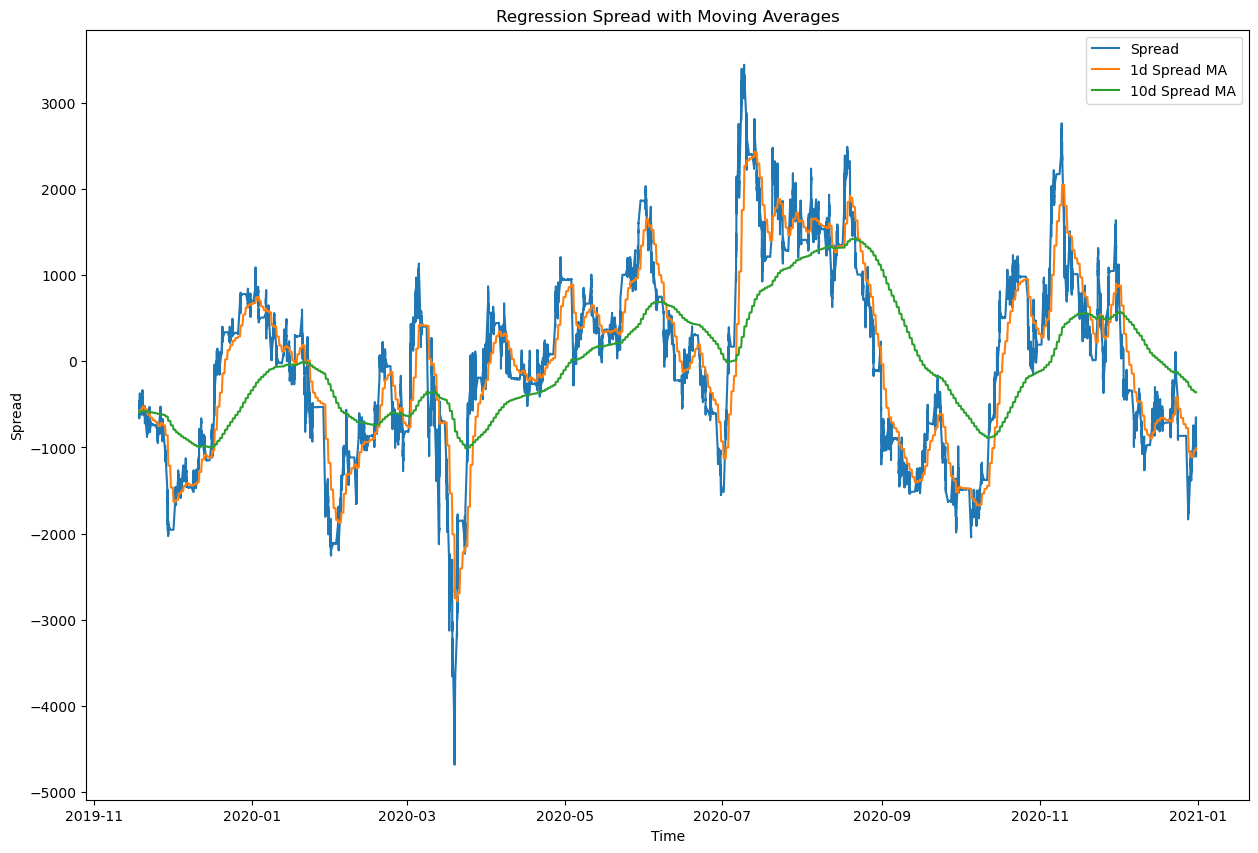

In [11]:
ema_short = df['Spread'].ewm(span=8640, adjust=False).mean()  # Short-term EMA
ema_long = df['Spread'].ewm(span=86400, adjust=False).mean()  # Long-term EMA
std_dev_ema = df['Spread'].ewm(span=86400, adjust=False).std()  # Standard deviation based on long-term EMA
z_score_ema = (ema_short - ema_long) / std_dev_ema

plt.figure(figsize=(15, 10))

# plot the original spread
plt.plot(df['Time'], df['Spread'].values, label='Spread')

# plot the 1-day and 10-day moving averages of the spread
plt.plot(df['Time'], ema_short.values, label='1d Spread MA')
plt.plot(df['Time'], ema_long.values, label='10d Spread MA')

plt.legend(['Spread', '1d Spread MA', '10d Spread MA'])
plt.title('Regression Spread with Moving Averages')
plt.ylabel('Spread')
plt.xlabel('Time')
plt.show()

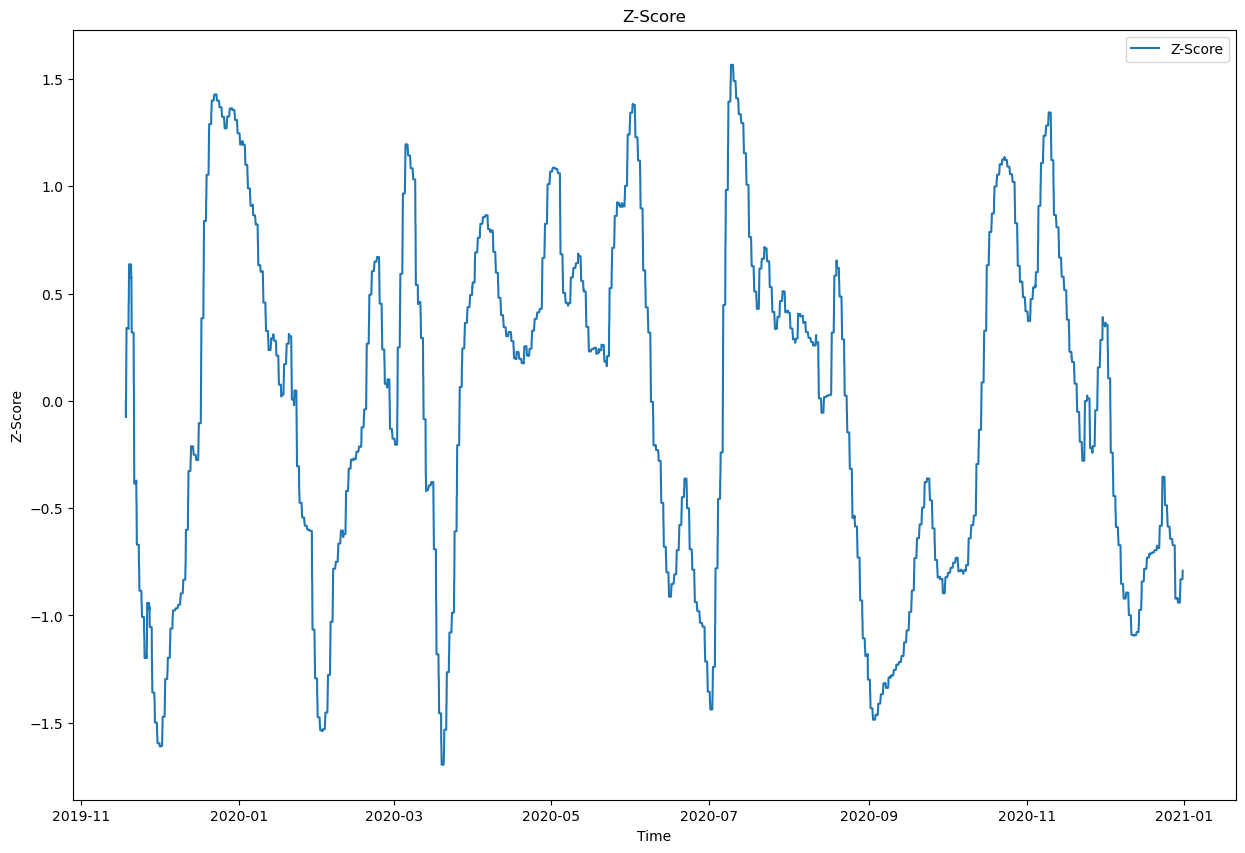

In [12]:
plt.figure(figsize=(15, 10))
plt.plot(df['Time'], z_score_ema, label='Z-Score')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Z-Score')
plt.title('Z-Score')
plt.show()

Visually inspecting the graph, at 2020-05 there is a point of interest in that it it doesn't return back into the negatives and actaully flips right back up. This could harm the models performance as there will be a long period of sell signals as its expecting to revert back to the mean

# Creating the Model

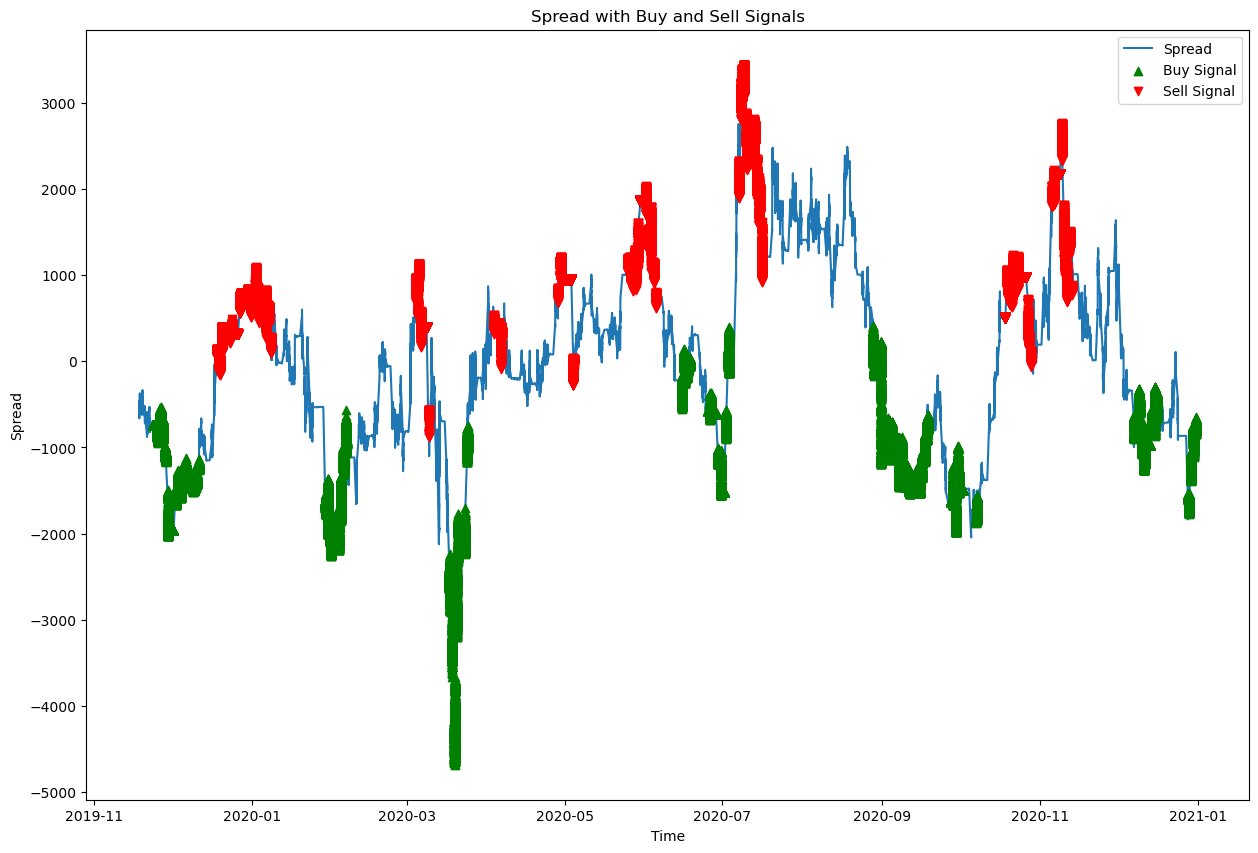

In [13]:
plt.figure(figsize=(15, 10))
plt.plot(df['Time'], df['Spread'].values, label='Spread', zorder=1)

binary_signals = np.zeros(len(df['Spread']))
# sell signal (overvaluation)
binary_signals[z_score_ema > 0.8] = -1
# buy signal (undervaluation)
binary_signals[z_score_ema < -0.8] = 1

buy_times = df['Time'][binary_signals == 1]
sell_times = df['Time'][binary_signals == -1]
buy_spreads = df['Spread'][binary_signals == 1]
sell_spreads = df['Spread'][binary_signals == -1]

plt.scatter(buy_times, buy_spreads, color='g', marker='^', label='Buy Signal', zorder=2)
plt.scatter(sell_times, sell_spreads, color='r', marker='v', label='Sell Signal', zorder=3)

plt.legend()
plt.xlabel('Time')
plt.ylabel('Spread')
plt.title('Spread with Buy and Sell Signals')
plt.show()


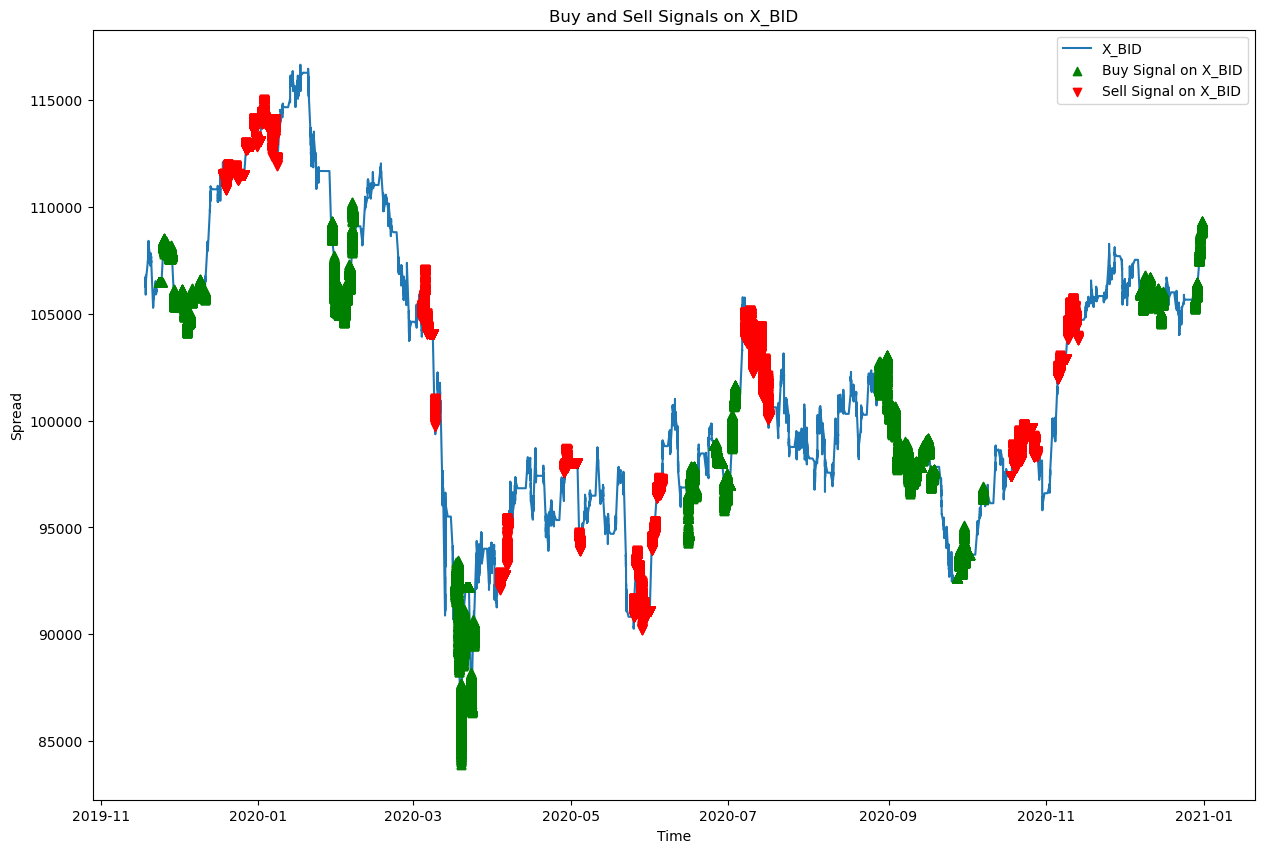

In [14]:
plt.figure(figsize=(15, 10))

plt.plot(df['Time'], df['X_BID'], label='X_BID', zorder=1)

# Plot buy signals
plt.scatter(buy_times, df['X_BID'][binary_signals == 1], color='g', marker='^', label='Buy Signal on X_BID', zorder=2)

# Plot sell signals
plt.scatter(sell_times, df['X_BID'][binary_signals == -1], color='r', marker='v', label='Sell Signal on X_BID', zorder=3)

plt.legend()
plt.xlabel('Time')
plt.ylabel('Spread')
plt.title('Buy and Sell Signals on X_BID')
plt.show()

The above graph shows buy and sell signals on X_BID. To evaluate the performance, I will train a classification model using supervised learning to see if it can predict these signals. Visually, the signals are somewhat accurate and there is hope for a good model.

# Testing models

In [15]:
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

X = df.drop(['Time'], axis=1)  # Drop non-feature columns
y = binary_signals  # Target variable (1 for buy, -1 for sell, 0 for hold)

# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Model Training
model = RandomForestClassifier(n_estimators=30, random_state=42)
model.fit(X_train_scaled, y_train)

# Prediction
predictions = model.predict(X_test_scaled)

# Evaluation
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

        -1.0       0.22      0.19      0.21     31386
         0.0       0.63      0.77      0.70    126117
         1.0       0.77      0.49      0.60     63767

    accuracy                           0.61    221270
   macro avg       0.54      0.48      0.50    221270
weighted avg       0.61      0.61      0.60    221270



This random forest has a class imbalance issue and performs poorly. It predicts a correct trading signal 61% of the time

Observations:
1. The model has a very low precision and recall for predicting sell signals (poor performance)
2. Performs best on hold signals - identifying when no action is required (mediocre performance)
3. When the model predicts a buy signal, it is correct 77% of the time, but recall of 49% means it misses most of the opportunities (mediocre performance)
4. Majority of instances are hold classes, possibly skewing the performance and favouring the majority

Improvements:
1. Using SMOTE to oversample minority classes, and adjusting class weights to improve class imbalance
2. Tuning hyperparameters and allowing more estimators (at the cost of computational time)
3. Possibly backtesting performance with historical data
4. Try different way / model

I will try the same model with cross validation

In [16]:
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.pipeline import make_pipeline

tscv = TimeSeriesSplit(n_splits=5)
pipeline = make_pipeline(StandardScaler(), RandomForestClassifier(n_estimators=30, random_state=42))

scores = cross_val_score(pipeline, X, y, cv=tscv, scoring='accuracy')

print(f"Cross-validation scores: {scores}")
print(f"Average score: {np.mean(scores)}")

Cross-validation scores: [0.73075891 0.7045889  0.3604741  0.60383805 0.59676068]
Average score: 0.5992841279783937


The output shows varying levels of scores, notably an outlier of 0.36 at the 3rd cross validation. Visually looking at the graph of X_BID confirms it. The current model doesn't predict well on small sine wave like patterns but better on larger drops and peaks. This suggests that the model can capture broader trends well but lacks sensitivity to finer, more subtle movements in the data or sudden market trend changes.

In [17]:
tscv = TimeSeriesSplit(n_splits=10)
pipeline = make_pipeline(StandardScaler(), RandomForestClassifier(n_estimators=30, random_state=42))

scores = cross_val_score(pipeline, X, y, cv=tscv, scoring='accuracy')

print(f"Cross-validation scores: {scores}")
print(f"Average score: {np.mean(scores)}")

Cross-validation scores: [0.80926459 0.70437428 0.75312822 0.70899763 0.49744225 0.33540141
 0.62261562 0.65891635 0.47881463 0.64342068]
Average score: 0.6212375654352658


By doing cross validation again with more splits, the training data in each fold becomes more homogeneous and less varied. Whilst it will help find smaller and more nuanced patterns it also takes computationally longer.

In [18]:
from sklearn.neighbors import KNeighborsClassifier

knn_model = KNeighborsClassifier(n_neighbors=15)
knn_model.fit(X_train, y_train)

predictions = knn_model.predict(X_test)

print(classification_report(y_test, predictions))


/Users/allenfang/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


              precision    recall  f1-score   support

        -1.0       0.22      0.19      0.21     31386
         0.0       0.62      0.73      0.67    126117
         1.0       0.67      0.48      0.56     63767

    accuracy                           0.58    221270
   macro avg       0.51      0.47      0.48    221270
weighted avg       0.58      0.58      0.57    221270



Again, the model doesn't perform well, and finding the best model to classify signals will take time

# Testing trade strategy

Going long on X at 106488.0 and short on Y at 105190.0
Closing long on X from 106488.0 to 111436.0 profit: 4948.0
Closing short on Y from 105190.0 to 110060.0 profit: -4870.0
Going short on X at 111428.0 and long on Y at 110060.0
Closing short on X from 111428.0 to 109056.0 profit: 2372.0
Closing long on Y from 110060.0 to 106400.0 profit: -3660.0
Going long on X at 109048.0 and short on Y at 106390.0
Closing long on X from 109048.0 to 104840.0 profit: -4208.0
Closing short on Y from 106390.0 to 105270.0 profit: 1120.0
Going short on X at 104848.0 and long on Y at 105270.0
Closing short on X from 104848.0 to 92024.0 profit: 12824.0
Closing long on Y from 105270.0 to 91230.0 profit: -14040.0
Going long on X at 92064.0 and short on Y at 91290.0
Closing long on X from 92064.0 to 92260.0 profit: 196.0
Closing short on Y from 91290.0 to 94550.0 profit: -3260.0
Going short on X at 92228.0 and long on Y at 94520.0
Closing short on X from 92228.0 to 96152.0 profit: -3924.0
Closing long on Y fr

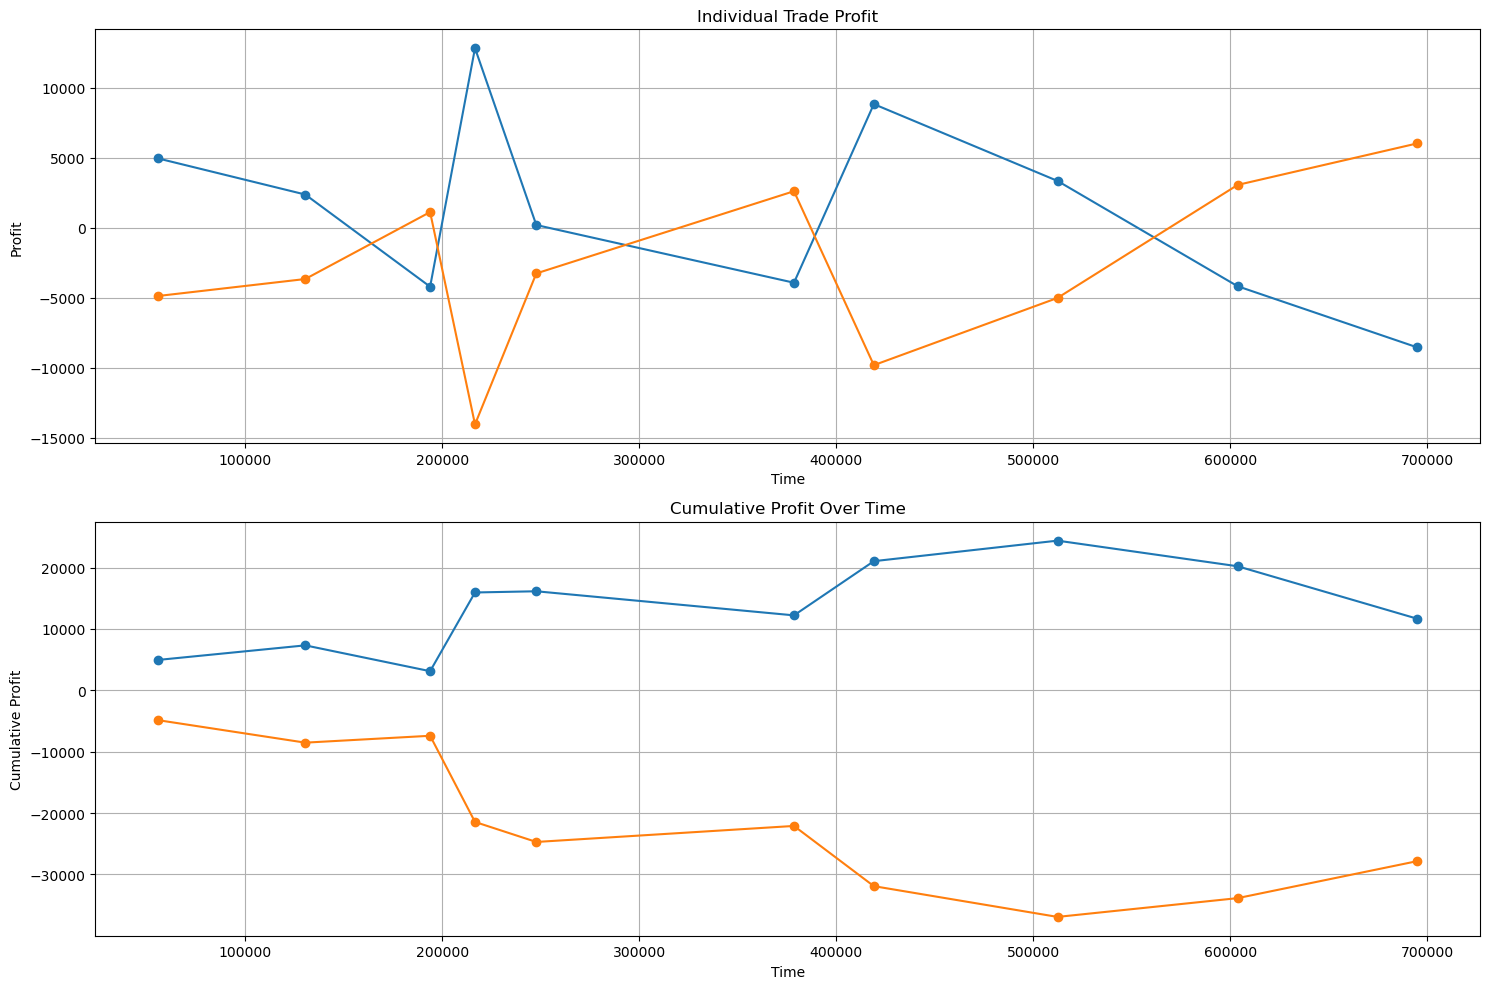

In [19]:
# Testing pair trading strategy

position_X = 0  # 1 for long, -1 for short, 0 for no position
position_Y = 0  # Opposite position for Y
trade_count = 0
profits_X = []
profits_Y = []
long_X = 0
short_X = 0
long_Y = 0
short_Y = 0
trade_times = []

for i in range(len(binary_signals)):
    if position_X == 0 and binary_signals[i] == 1:  # Buy signal for X
        position_X = 1  # Going long on X
        position_Y = -1  # Going short on Y
        long_X = df['X_BID'].iloc[i]
        short_Y = df['Y_ASK'].iloc[i]  # Assuming you have similar columns for Y
        print("Going long on X at", long_X, "and short on Y at", short_Y)
    elif position_X == 1 and binary_signals[i] == -1:  # Sell signal to close long position on X
        position_X = 0  # Closing position on X
        position_Y = 0  # Closing position on Y
        profit_X = df['X_ASK'].iloc[i] - long_X
        profit_Y = short_Y - df['Y_BID'].iloc[i]  # Buy back Y at bid price
        profits_X.append(profit_X)
        profits_Y.append(profit_Y)
        trade_count += 1
        trade_times.append(i)
        print("Closing long on X from", long_X, "to", df['X_ASK'].iloc[i], "profit:", profit_X)
        print("Closing short on Y from", short_Y, "to", df['Y_BID'].iloc[i], "profit:", profit_Y)
    elif position_X == 0 and binary_signals[i] == -1:  # Sell signal for going short on X
        position_X = -1  # Going short on X
        position_Y = 1  # Going long on Y
        short_X = df['X_ASK'].iloc[i]
        long_Y = df['Y_BID'].iloc[i]  # Buy Y at bid price
        print("Going short on X at", short_X, "and long on Y at", long_Y)
    elif position_X == -1 and binary_signals[i] == 1:  # Buy signal to close short position on X
        position_X = 0  # Closing position on X
        position_Y = 0  # Closing position on Y
        profit_X = short_X - df['X_BID'].iloc[i]
        profit_Y = df['Y_ASK'].iloc[i] - long_Y  # Sell Y at ask price
        profits_X.append(profit_X)
        profits_Y.append(profit_Y)
        trade_count += 1
        trade_times.append(i)
        print("Closing short on X from", short_X, "to", df['X_BID'].iloc[i], "profit:", profit_X)
        print("Closing long on Y from", long_Y, "to", df['Y_ASK'].iloc[i], "profit:", profit_Y)

total_profit_X = sum(profits_X)
total_profit_Y = sum(profits_Y)
total_profit = total_profit_X + total_profit_Y
print(f"Total Profit for X: {total_profit_X}")
print(f"Total Profit for Y: {total_profit_Y}")
print(f"Combined Total Profit: {total_profit}")
print(f"Number of Trades: {trade_count}")
if trade_count > 0:
    print(f"Average profit per trade for X: {(total_profit_X / trade_count):.2f}")
    print(f"Average profit per trade for Y: {(total_profit_Y / trade_count):.2f}")
else:
    print("No trades executed.")

# Calculate cumulative profit
cumulative_profit_X = np.cumsum(profits_X)
cumulative_profit_Y = np.cumsum(profits_Y)

# Create subplots
fig, axs = plt.subplots(2, 1, figsize=(15, 10))

# Plot individual trade profits
axs[0].plot(trade_times, profits_X, marker='o')
axs[0].plot(trade_times, profits_Y, marker='o')
axs[0].set_title('Individual Trade Profit')
axs[0].set_xlabel('Time')
axs[0].set_ylabel('Profit')
axs[0].grid(True)

# Plot cumulative profit
axs[1].plot(trade_times, cumulative_profit_X, marker='o', linestyle='-')
axs[1].plot(trade_times, cumulative_profit_Y, marker='o', linestyle='-')
axs[1].set_title('Cumulative Profit Over Time')
axs[1].set_xlabel('Time')
axs[1].set_ylabel('Cumulative Profit')
axs[1].grid(True)

plt.tight_layout()
plt.show()


The consistent losses from stock Y in the pairs trading setup suggest that its price movements were not adequately counterbalanced by those of stock X. This is counter intutitive because the pair were found to be cointegrated and thus should exhibit spread mean-reverting. Instead, stock Y's movements were more aligned with stock X, negating the effectiveness of the pairs trading strategy. Seeing a direct reflection along $y=0$ of the cumulative profit graph of X and Y, I will try a synchronized strategy instead.

Going long on X at 106488.0 and Y at 105170.0
Closing long on X from 106488.0 to 111436.0 profit: 4948.0
Closing long on Y from 105170.0 to 110070.0 profit: 4900.0
Going short on X at 111428.0 and Y at 110070.0
Closing short on X from 111428.0 to 109056.0 profit: 2372.0
Closing short on Y from 110070.0 to 106390.0 profit: 3680.0
Going long on X at 109048.0 and Y at 106380.0
Closing long on X from 109048.0 to 104840.0 profit: -4208.0
Closing long on Y from 106380.0 to 105280.0 profit: -1100.0
Going short on X at 104848.0 and Y at 105280.0
Closing short on X from 104848.0 to 92024.0 profit: 12824.0
Closing short on Y from 105280.0 to 91220.0 profit: 14060.0
Going long on X at 92064.0 and Y at 91270.0
Closing long on X from 92064.0 to 92260.0 profit: 196.0
Closing long on Y from 91270.0 to 94570.0 profit: 3300.0
Going short on X at 92228.0 and Y at 94540.0
Closing short on X from 92228.0 to 96152.0 profit: -3924.0
Closing short on Y from 94540.0 to 97120.0 profit: -2580.0
Going long on X 

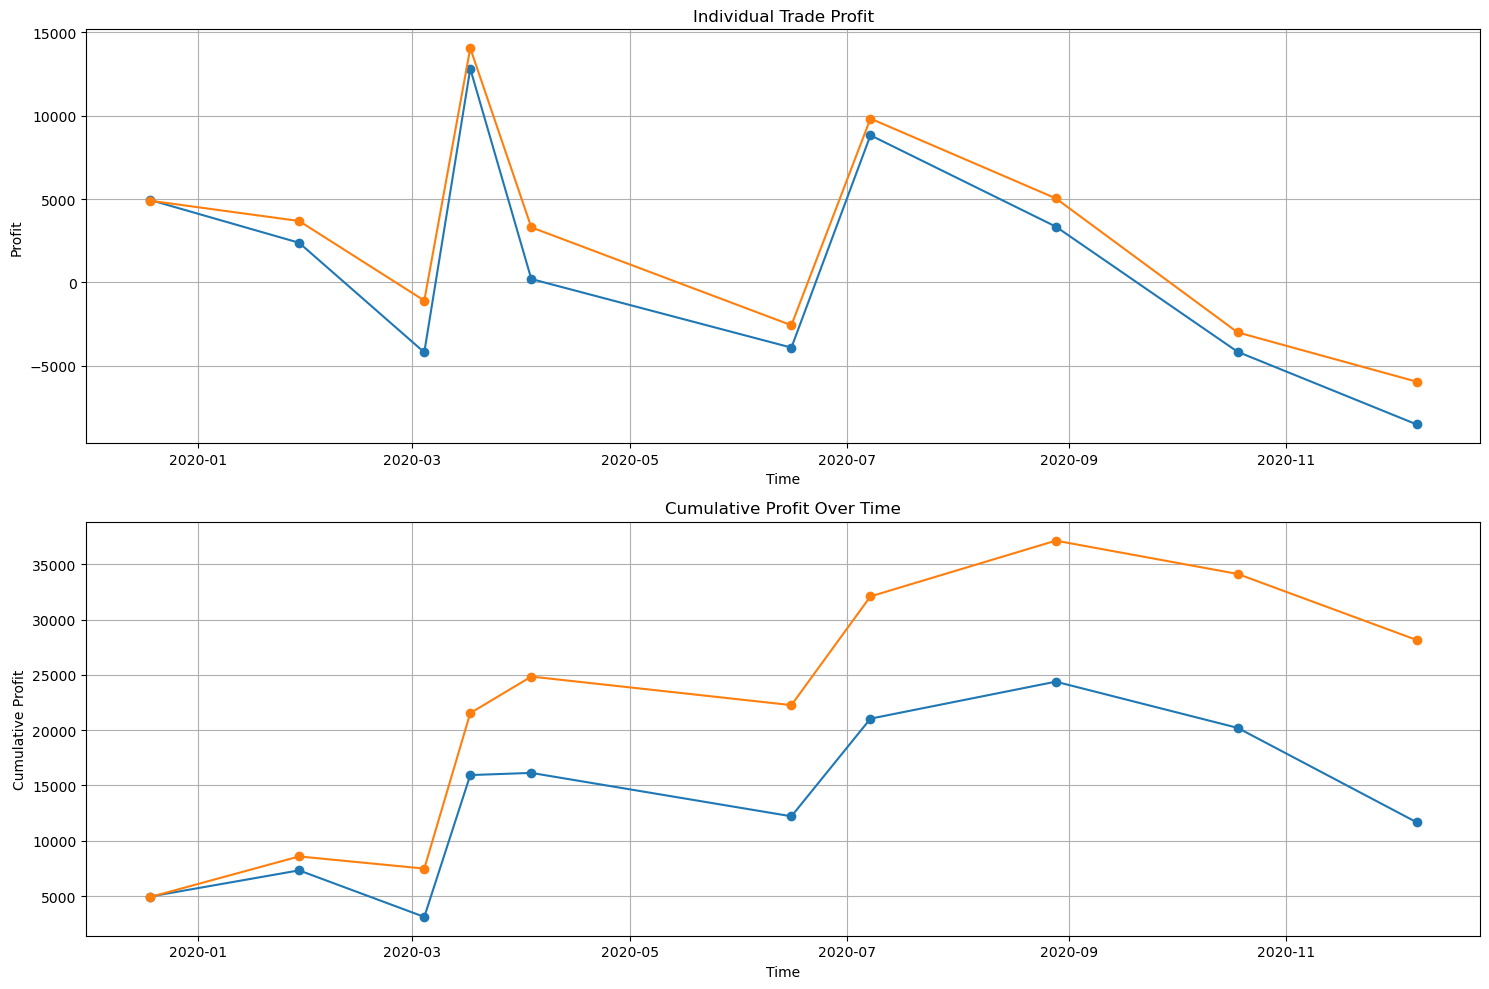

In [20]:
# Synchronized strategy
position = 0  # 1 for long, -1 for short, 0 for no position
trade_count = 0
trade_times = []
profits_X = []
profits_Y = []
long_X = 0
short_X = 0
long_Y = 0
short_Y = 0

for i in range(len(binary_signals)):
    if position == 0 and binary_signals[i] == 1:  # Buy signal
        position = 1  # Going long on both X and Y
        long_X = df['X_BID'].iloc[i]  # Buy X at bid price
        long_Y = df['Y_BID'].iloc[i]  # Buy Y at bid price, assuming similar structure for Y
        print("Going long on X at", long_X, "and Y at", long_Y)
    elif position == 1 and binary_signals[i] == -1:  # Sell signal to close long position
        position = 0  # Closing position for both X and Y
        profit_X = df['X_ASK'].iloc[i] - long_X  # Sell X at ask price
        profit_Y = df['Y_ASK'].iloc[i] - long_Y  # Sell Y at ask price
        profits_X.append(profit_X)
        profits_Y.append(profit_Y)
        trade_count += 1  # Increment trade count
        trade_times.append(df['Time'].iloc[i])
        print("Closing long on X from", long_X, "to", df['X_ASK'].iloc[i], "profit:", profit_X)
        print("Closing long on Y from", long_Y, "to", df['Y_ASK'].iloc[i], "profit:", profit_Y)
    elif position == 0 and binary_signals[i] == -1:  # Sell signal for going short
        position = -1  # Going short on both X and Y
        short_X = df['X_ASK'].iloc[i]  # Sell X at ask price
        short_Y = df['Y_ASK'].iloc[i]  # Sell Y at ask price
        print("Going short on X at", short_X, "and Y at", short_Y)
    elif position == -1 and binary_signals[i] == 1:  # Buy signal to close short position
        position = 0  # Closing position for both X and Y
        profit_X = short_X - df['X_BID'].iloc[i]  # Buy back X at bid price
        profit_Y = short_Y - df['Y_BID'].iloc[i]  # Buy back Y at bid price
        profits_X.append(profit_X)
        profits_Y.append(profit_Y)
        trade_count += 1  # Increment trade count
        trade_times.append(df['Time'].iloc[i])
        print("Closing short on X from", short_X, "to", df['X_BID'].iloc[i], "profit:", profit_X)
        print("Closing short on Y from", short_Y, "to", df['Y_BID'].iloc[i], "profit:", profit_Y)

total_profit_X = sum(profits_X)
total_profit_Y = sum(profits_Y)
combined_total_profit = total_profit_X + total_profit_Y
print(f"Total Profit for X: {total_profit_X}")
print(f"Total Profit for Y: {total_profit_Y}")
print(f"Combined Total Profit: {combined_total_profit}")
print(f"Number of Trades: {trade_count}")
if trade_count > 0:
    print(f"Average profit per trade for X: {(total_profit_X / trade_count):.2f}")
    print(f"Average profit per trade for Y: {(total_profit_Y / trade_count):.2f}")
else:
    print("No trades executed.")
    
# Calculate cumulative profit
cumulative_profit_X = np.cumsum(profits_X)
cumulative_profit_Y = np.cumsum(profits_Y)

# Create subplots
fig, axs = plt.subplots(2, 1, figsize=(15, 10))

# Plot individual trade profits
axs[0].plot(trade_times, profits_X, marker='o')
axs[0].plot(trade_times, profits_Y, marker='o')
axs[0].set_title('Individual Trade Profit')
axs[0].set_xlabel('Time')
axs[0].set_ylabel('Profit')
axs[0].grid(True)

# Plot cumulative profit
axs[1].plot(trade_times, cumulative_profit_X, marker='o', linestyle='-')
axs[1].plot(trade_times, cumulative_profit_Y, marker='o', linestyle='-')
axs[1].set_title('Cumulative Profit Over Time')
axs[1].set_xlabel('Time')
axs[1].set_ylabel('Cumulative Profit')
axs[1].grid(True)

plt.tight_layout()
plt.show()

The important logs are that:

Total Profit for X: 11668.0

Total Profit for Y: 28150.0

Combined Total Profit: 39818.0

Number of Trades: 10

Average profit per trade for X: 1166.80

Average profit per trade for Y: 2815.00

Unlike the pairs trading scenario, applying the same directional strategy to both instruments has led to a consistent overall profit. In fact, Y had a higher average profitability than X, ending with a net profit of $39818 with Y responsible for 70\% of the profits and X responsible for 30\%. 

The graph also shows that the current strategy has a tendency to make some positive trades followed by some negative trades. This cyclical pattern could be due to market cycles, inherent volatility or overfitting. However the general pattern is that the positive trades slowly outweigh the negative trades.

A viable hypothesis with the current model is to make $x$ positive trades, then skip the next $y$ trade (assuming pattern persists such as observing if the pattern persists in the years 2021-2023) where x and y will be found by backtesting

# Conclusion
The synchronized trading strategy netting positive indicates that these signals are a good indicator for the future. However, testing this with the data from 2021-2023 will strengthen the claim and reveal any underlying issues. Additionally I did not find a machine learning model that was able to classify these signals correctly.

Based off what is currently done, my trading strategy with instrument X and Y would be to synchronize my long and short positions with both of them. I will do for example 2 trades then skip 1 trade to avoid the negative trade pattern shown above. 

Improvements:
1. Stop loss mechanism, when the market suddenly behaves differently such as during the COVID pandemic, I need to be able to stop the model at a given point as the assumptions might not hold anymore
2. Instead of a threshold for the z-score (0.8 and -0.8), a dynamic one that is based off the previous market behaviour will improve the detection of signals and be more resilient to anomalies
3. While the cyclical pattern has a strategic benefit, the negative trade could be due to overfitting and once again will be improved on across different time data
4. Testing stationarity and cointegration was only done on a subset of 20%, yet it took over 2 minutes! Verifying the whole dataset will be much more reliable
5. The model handles bigger, sensitive patterns but cannot classify well on short sine wave like patterns or sudden market changes - more training needed on periods which exhibit this
6. Pairs trading strategy did not work as hoped, and synchronized worked better. This indicates that whilist X and Y were correlated and cointegrated, they did not exhibit large divergences that could be exploited with mean reversion
7. I only took the median signal of each 'section' of signals in an attempt to 'average' it out. A clustering model to automatically pick the best signal will improve the signals
8. I did not actually test the signals, such as using an equity curve and rather visually assessed it looked good
9. Conducting backtesting using this strategy on data from 2021-2023 will provide insights into its effectiveness and possibility for real world deployment
10. Only 1 unit was bought which is a randomly chosen value, choosing the best volume against risk will need feature engineering and risk management
11. Volume columns in the dataset were rarely used, even though these factors could've affected the nature of the prices. Methods such as including weights of the price pressure, imbalances and sudden breakouts could have skewed the model in a positive way
12. Finding a model that will capture the nuances and patterns in the best way will be complex and iterative